In [104]:
import pandas as pd
import ast
import wfdb
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torchinfo import summary
import torchvision
import torcheval

import pywt
import math
import random
from collections import Counter

sns.set_style('darkgrid')
pd.set_option('display.max_columns', None)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Работа с исходными данными

## Обработка метаданных

Загрузим метаданные о датасете и данные о диагнозах

In [2]:
meta_df = pd.read_csv('ptbxl_database.csv', index_col=0)
scp_df = pd.read_csv('scp_statements.csv')

meta_df

,patient_id,age,sex,height,weight,nurse,site,device,recording_date,report,scp_codes,heart_axis,infarction_stadium1,infarction_stadium2,validated_by,second_opinion,initial_autogenerated_report,validated_by_human,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr
ecg_id,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,sinusrhythmus periphere niederspannung,"{'NORM': 100.0, 'LVOLT': 0.0, 'SR': 0.0}",NaN,NaN,NaN,NaN,False,False,True,NaN,", I-V1,",NaN,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr
2,13243.0,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,sinusbradykardie sonst normales ekg,"{'NORM': 80.0, 'SBRAD': 0.0}",NaN,NaN,NaN,NaN,False,False,True,NaN,NaN,NaN,NaN,NaN,NaN,2,records100/00000/00002_lr,records500/00000/00002_hr
3,20372.0,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1984-11-15 12:49:10,sinusrhythmus normales ekg,"{'NORM': 100.0, 'SR': 0.0}",NaN,NaN,NaN,NaN,False,False,True,NaN,NaN,NaN,NaN,NaN,NaN,5,records100/00000/00003_lr,records500/00000/00003_hr
4,17014.0,24.0,0,NaN,82.0,2.0,0.0,CS-12 E,1984-11-15 13:44:57,sinusrhythmus normales ekg,"{'NORM': 100.0, 'SR': 0.0}",NaN,NaN,NaN,NaN,False,False,True,", II,III,AVF",NaN,NaN,NaN,NaN,NaN,3,records100/00000/00004_lr,records500/00000/00004_hr
5,17448.0,19.0,1,NaN,70.0,2.0,0.0,CS-12 E,1984-11-17 10:43:15,sinusrhythmus normales ekg,"{'NORM': 100.0, 'SR': 0.0}",NaN,NaN,NaN,NaN,False,False,True,", III,AVR,AVF",NaN,NaN,NaN,NaN,NaN,4,records100/00000/00005_lr,records500/00000/00005_hr
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21833,17180.0,67.0,1,NaN,NaN,1.0,2.0,AT-60 3,2001-05-31 09:14:35,ventrikulÄre extrasystole(n) sinustachykardie ...,"{'NDT': 100.0, 'PVC': 100.0, 'VCLVH': 0.0, 'ST...",LAD,NaN,NaN,1.0,False,True,True,NaN,", alles,",NaN,NaN,1ES,NaN,7,records100/21000/21833_lr,records500/21000/21833_hr
21834,20703.0,93.0,0,NaN,NaN,1.0,2.0,AT-60 3,2001-06-05 11:33:39,sinusrhythmus lagetyp normal qrs(t) abnorm ...,"{'NORM': 100.0, 'ABQRS': 0.0, 'SR': 0.0}",MID,Stadium II-III,NaN,1.0,False,True,True,NaN,NaN,NaN,NaN,NaN,NaN,4,records100/21000/21834_lr,records500/21000/21834_hr
21835,19311.0,59.0,1,NaN,NaN,1.0,2.0,AT-60 3,2001-06-08 10:30:27,sinusrhythmus lagetyp normal t abnorm in anter...,"{'ISCAS': 50.0, 'SR': 0.0}",MID,NaN,NaN,1.0,True,True,True,NaN,", I-AVR,",NaN,NaN,NaN,NaN,2,records100/21000/21835_lr,records500/21000/21835_hr


Отфильтруем данные.

В метаданных нужно оставить столбцы, включающие в себя диагноз, путь к файлу с временным рядом, разделения на 10 групп. Обработаем столбец с заключениями в соответствии с синтаксисом словаря.

В данных о диагнозах оставим только диагностические заключения

In [3]:
meta_df.scp_codes = meta_df.scp_codes.apply(lambda x: ast.literal_eval(x))
meta_df = meta_df[['scp_codes', 'strat_fold', 'filename_lr']]


scp_df = scp_df[scp_df.diagnostic == 1]
diagnose_set = set(scp_df['Unnamed: 0'])

meta_df

,scp_codes,strat_fold,filename_lr
ecg_id,,,
1,"{'NORM': 100.0, 'LVOLT': 0.0, 'SR': 0.0}",3,records100/00000/00001_lr
2,"{'NORM': 80.0, 'SBRAD': 0.0}",2,records100/00000/00002_lr
3,"{'NORM': 100.0, 'SR': 0.0}",5,records100/00000/00003_lr
4,"{'NORM': 100.0, 'SR': 0.0}",3,records100/00000/00004_lr
5,"{'NORM': 100.0, 'SR': 0.0}",4,records100/00000/00005_lr
...,...,...,...
21833,"{'NDT': 100.0, 'PVC': 100.0, 'VCLVH': 0.0, 'ST...",7,records100/21000/21833_lr
21834,"{'NORM': 100.0, 'ABQRS': 0.0, 'SR': 0.0}",4,records100/21000/21834_lr
21835,"{'ISCAS': 50.0, 'SR': 0.0}",2,records100/21000/21835_lr


## Загрузка временных рядов

Для дальнейшего анализа будем использовать записи с частотой 100 измерений в секунду. Загрузим записи в numpy массив

In [4]:
def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data

path = ''
sampling_rate=100

X = load_raw_data(meta_df, sampling_rate, path)
X = X.transpose(0,2,1)
X.shape

(21837, 12, 1000)

Размер полученных данных соответствует 21837 случаям, для каждого проведено 12 одновременных измерений по 10*100=1000 точек

Визуализируем одно из ЭКГ

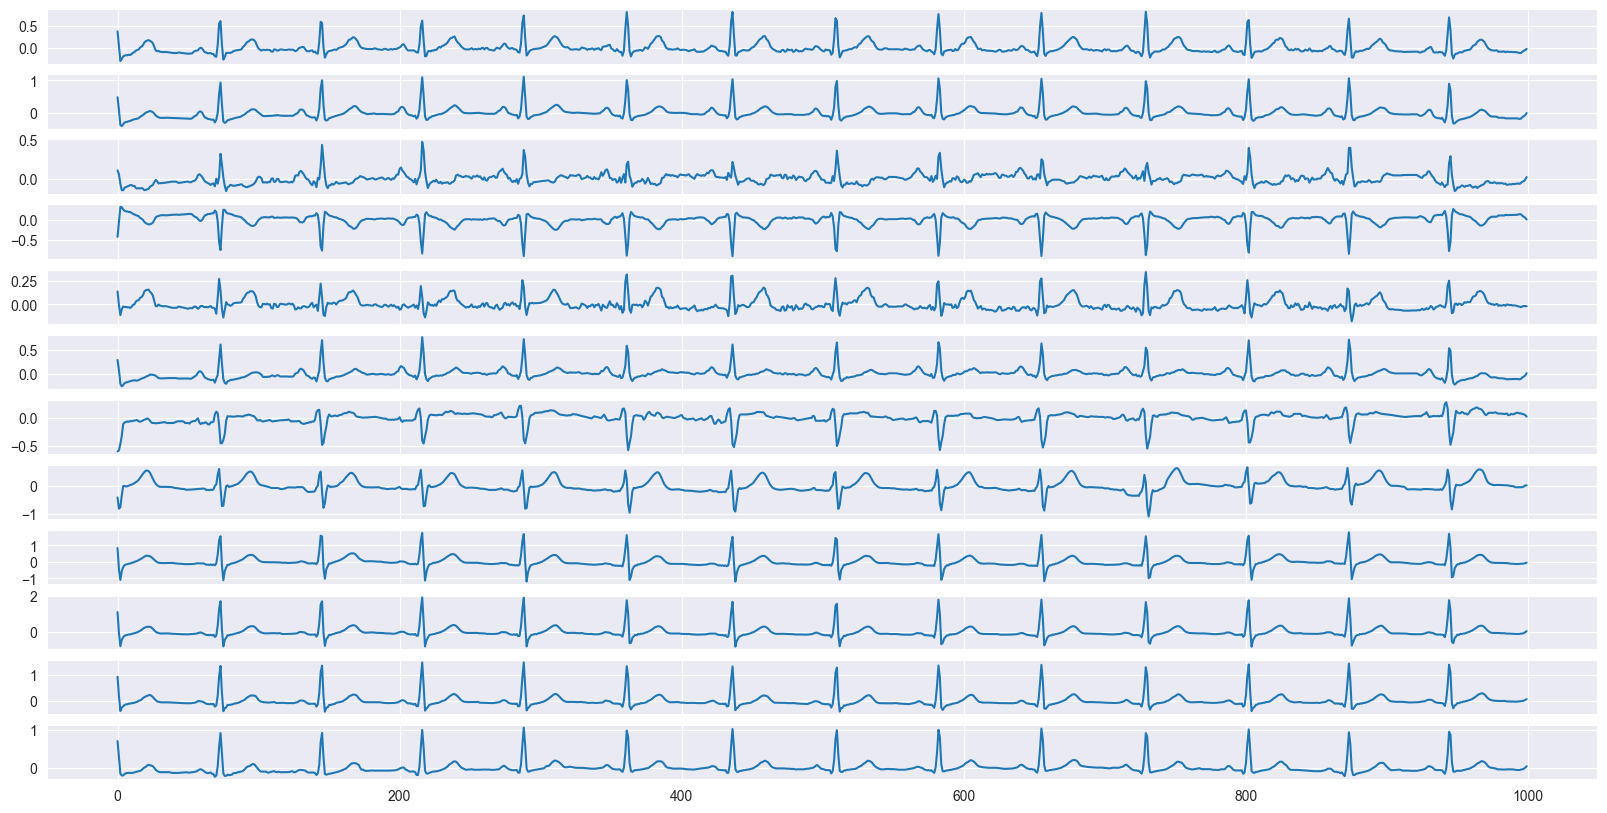

In [5]:
sample = X[45]

fig, axes = plt.subplots(12, 1, figsize=(20,10), sharex=True)
for i in range(12):
    sns.lineplot(x=np.arange(sample.shape[1]), y=sample[i, :], ax=axes[i])
plt.show()

## Разметка данных

Разметим ЭКГ, будем использовать только диагностические заметки, уровень будет равен степени уверенности в диагнозе

In [6]:
def marking(labels, classes):
    # Словарь для индексов классов
    classes_dict = {key: value for key, value in zip(classes, range(len(classes)))}
    res = np.zeros([len(labels), len(classes)])
    # Пройдёмся по каждому диагнозу, в нём просматриваем словарь, проверяем входит ли запись в диагнозы и, если да, то записываем значение в пределах [0,1]
    for i, ecg in enumerate(labels):
        for key, value in ecg.items():
            if key in classes_dict:
                j = classes_dict[key]
                res[i,j] = value/100
    return res    
    

In [7]:
Y = marking(meta_df.scp_codes, diagnose_set)

In [8]:
test_fold = [10]

X_test = []
Y_test = []
X_train = []
Y_train = []

for i in range(len(meta_df)):
    if Y[i].sum() == 0:
        continue
    if meta_df.iloc[i]['strat_fold'] in test_fold:
        X_test.append(X[i])
        Y_test.append(Y[i])
    else:
        X_train.append(X[i])
        Y_train.append(Y[i])
    print(f"Done {i} of {len(meta_df)}", end='\r')

X_test = np.array(X_test)
Y_test = np.array(Y_test)
X_train = np.array(X_train)
Y_train = np.array(Y_train)

## Анализ данных

#### Определение функций

In [9]:
def num_classes_row(data, name):
    count = np.zeros(len(diagnose_set))
    for row in data:
        num = (row > 0).sum()
        count[num] += 1
    plt.figure(figsize=(20, 6))
    plt.bar(np.arange(len(diagnose_set)), count)
    plt.title(f"Распределение количества диагнозов по ЭКГ в {name} датасете")
    plt.show()
    print({num: cnt for num, cnt in zip(range(len(count)), count)})


def num_classes_dataset(data, name):
    count = (data > 0).sum(axis=0)
    plt.figure(figsize=(20, 6))
    plt.bar(list(diagnose_set), count)
    plt.xticks(rotation=60)
    plt.title(f"Распределение частоты диагнозов в {name} датасете")
    plt.show()

def sum_coef_classes_dataset(data, name):
    count = data.sum(axis=0)
    plt.figure(figsize=(20, 6))
    plt.bar(list(diagnose_set), count)
    plt.xticks(rotation=60)
    plt.title(f"Распределение диагнозов, учитывая стпень уверенности в {name} датасете")
    plt.show()


def avg_coef_classes_dataset(data, name):
    count1 = data.sum(axis=0)
    count2 = (data > 0).sum(axis=0)
    avg_count = count1 / count2
    plt.figure(figsize=(20, 6))
    plt.bar(list(diagnose_set), avg_count)
    plt.xticks(rotation=60)
    plt.title(f"Распределение средней уверенности в диагнозе в {name} датасете")
    plt.show()
    

#### Анализ обучающего и тестового датасетов

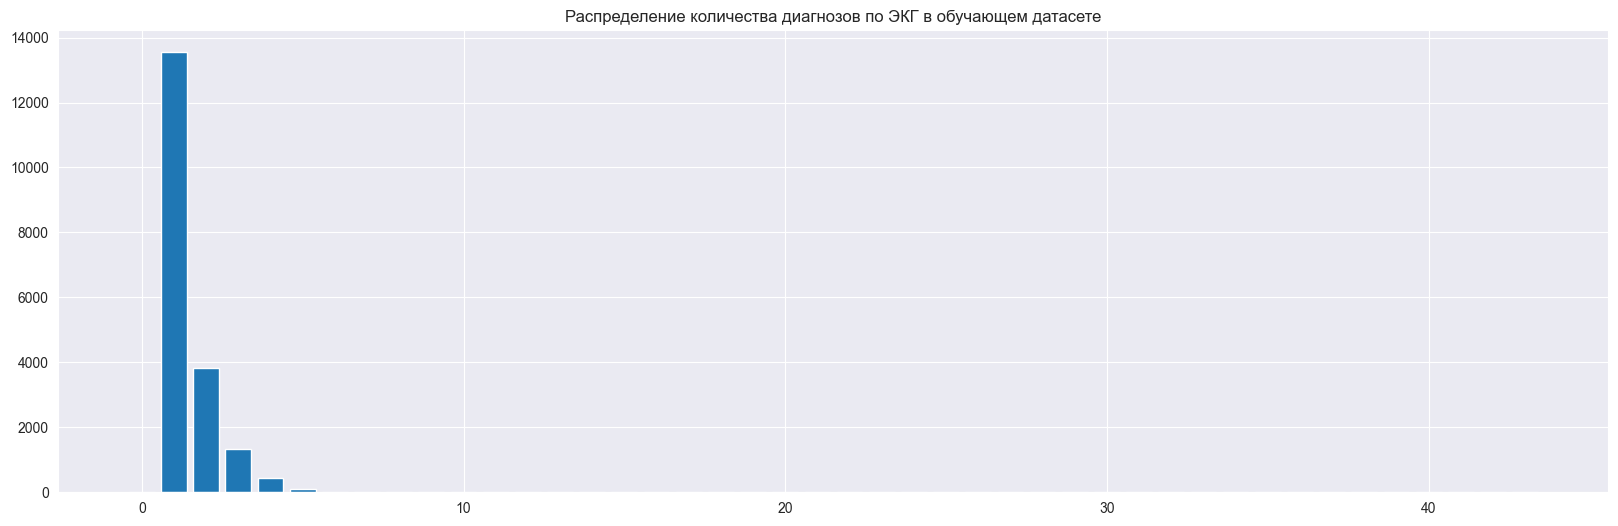

{0: 0.0, 1: 13547.0, 2: 3817.0, 3: 1333.0, 4: 454.0, 5: 104.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.0, 13: 0.0, 14: 0.0, 15: 0.0, 16: 0.0, 17: 0.0, 18: 0.0, 19: 0.0, 20: 0.0, 21: 0.0, 22: 0.0, 23: 0.0, 24: 0.0, 25: 0.0, 26: 0.0, 27: 0.0, 28: 0.0, 29: 0.0, 30: 0.0, 31: 0.0, 32: 0.0, 33: 0.0, 34: 0.0, 35: 0.0, 36: 0.0, 37: 0.0, 38: 0.0, 39: 0.0, 40: 0.0, 41: 0.0, 42: 0.0, 43: 0.0}


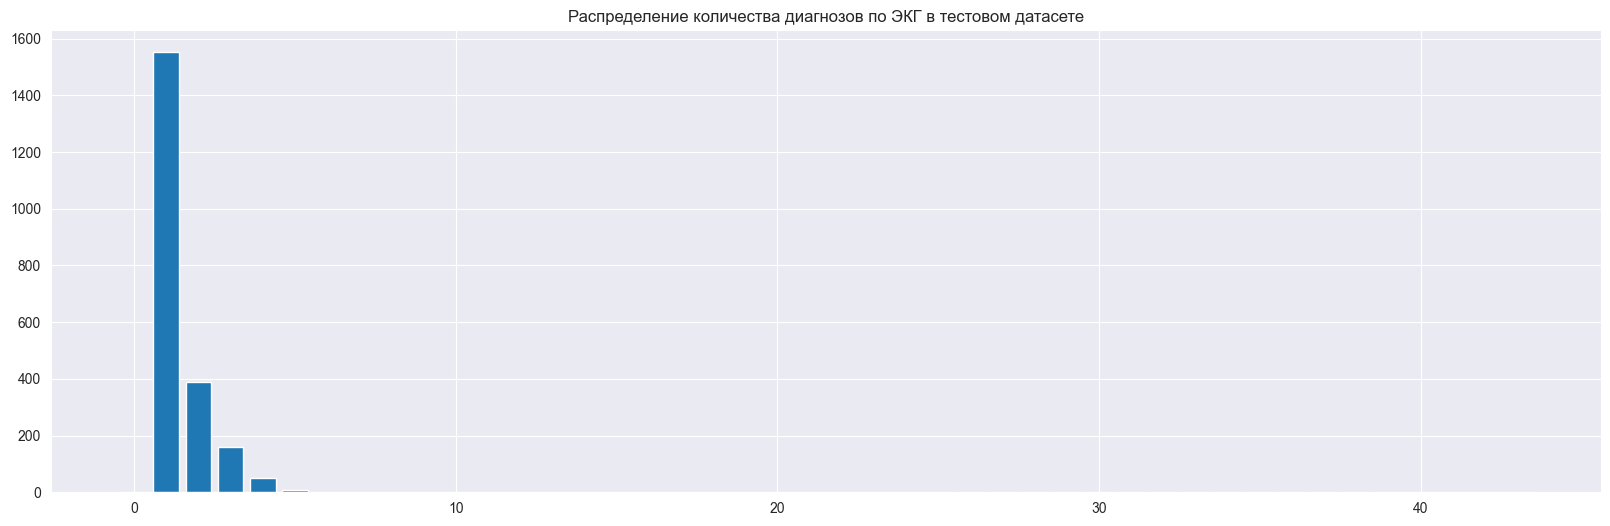

{0: 0.0, 1: 1552.0, 2: 388.0, 3: 161.0, 4: 52.0, 5: 9.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.0, 13: 0.0, 14: 0.0, 15: 0.0, 16: 0.0, 17: 0.0, 18: 0.0, 19: 0.0, 20: 0.0, 21: 0.0, 22: 0.0, 23: 0.0, 24: 0.0, 25: 0.0, 26: 0.0, 27: 0.0, 28: 0.0, 29: 0.0, 30: 0.0, 31: 0.0, 32: 0.0, 33: 0.0, 34: 0.0, 35: 0.0, 36: 0.0, 37: 0.0, 38: 0.0, 39: 0.0, 40: 0.0, 41: 0.0, 42: 0.0, 43: 0.0}


In [10]:
num_classes_row(Y_train, 'обучающем')
num_classes_row(Y_test, 'тестовом')

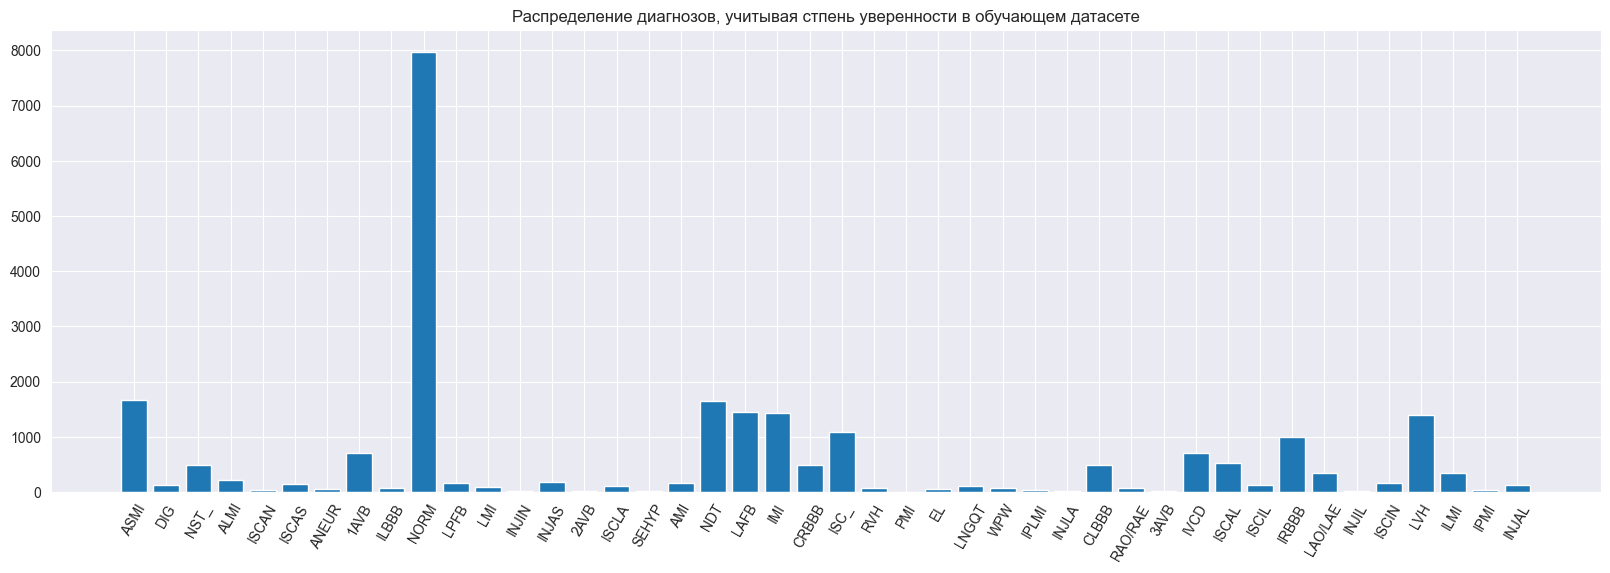

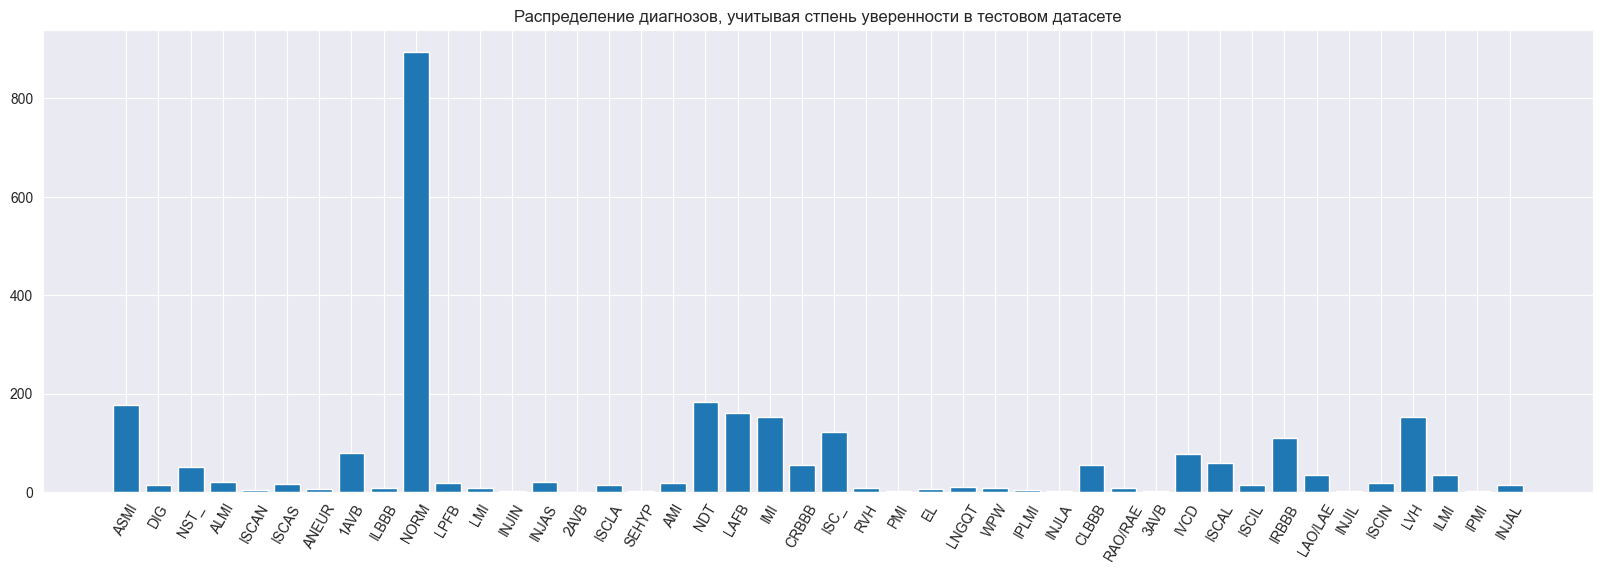

In [11]:
sum_coef_classes_dataset(Y_train, 'обучающем')
sum_coef_classes_dataset(Y_test, 'тестовом')

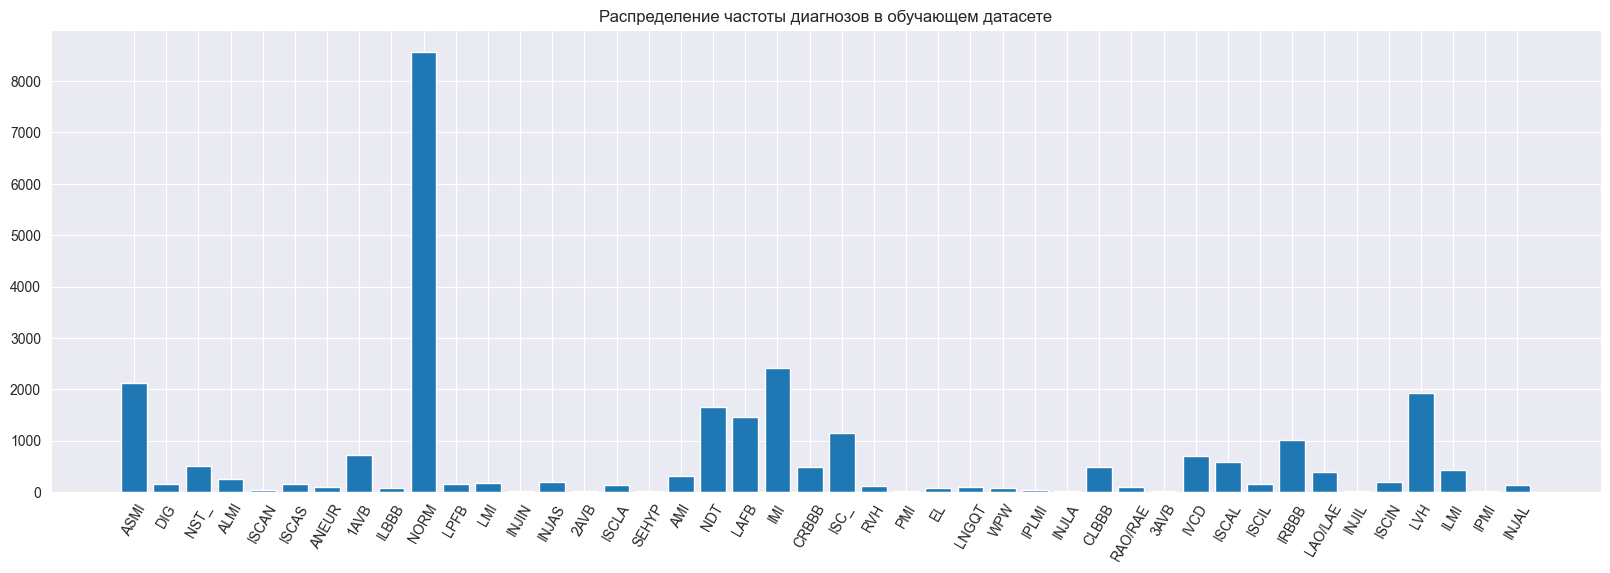

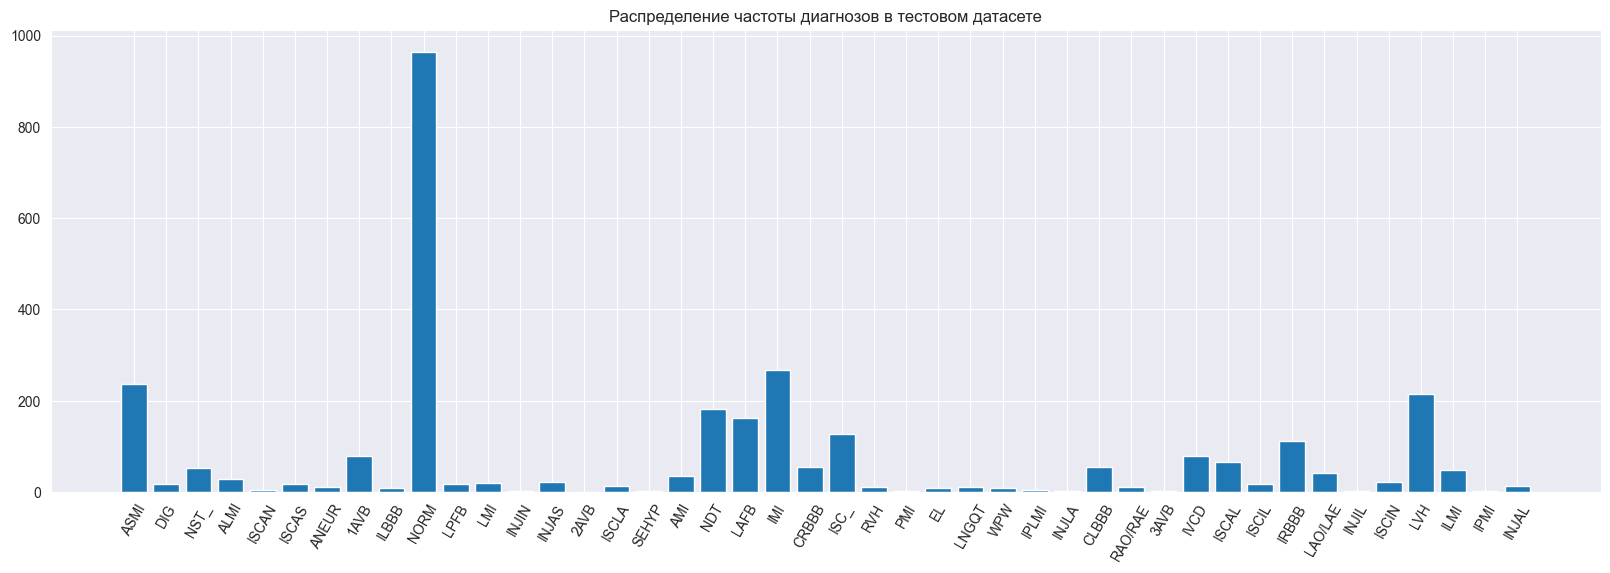

In [12]:
num_classes_dataset(Y_train, 'обучающем')
num_classes_dataset(Y_test, 'тестовом')

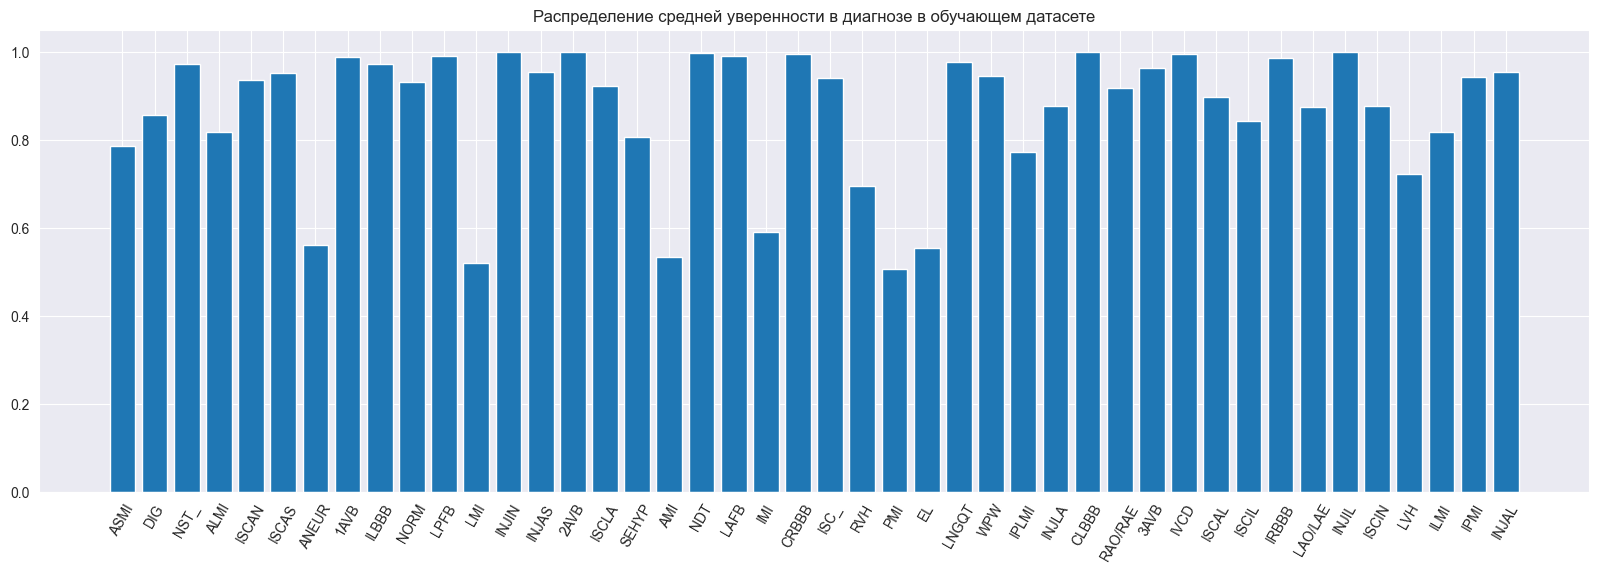

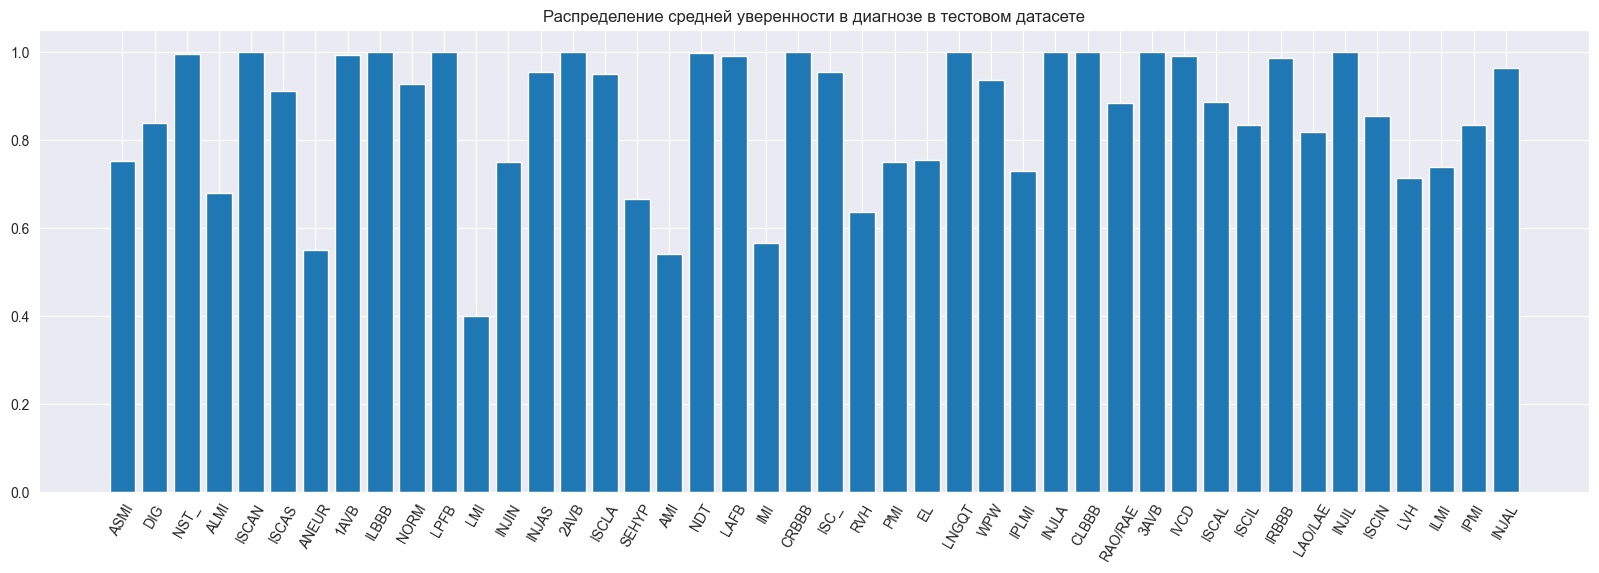

In [13]:
avg_coef_classes_dataset(Y_train, 'обучающем')
avg_coef_classes_dataset(Y_test, 'тестовом')

## Балансировка обучающего датасета

#### Определение авторского метода балансировки

In [14]:
def Prob(x, threshold_inf):
    if x <= threshold_inf:
        return 0
    return 1 / (1 + math.exp(-math.log(x)))


def get_information(values, distribution_0):
    arr = np.zeros(len(values))
    for i in range(len(arr)):
        arr[i] = -math.log2(abs(values[i] - 1/distribution_0[i]))        
    return np.sqrt(np.mean(arr**2))


def multiply(dataX, dataY, threshold_i, threshold_p):
    distribution0 = 1 - dataY.sum(axis=0)/len(dataY)
    # print(distribution0)
    information = [get_information(row, distribution0) for row in dataY]
    multiply_probability = [Prob(information_value,threshold_i) for information_value in information]
    dataY = list(dataY)
    dataX = list(dataX)
    for i in range(len(dataY)):
        if random.random() < multiply_probability[i] and multiply_probability[i] > threshold_p:
            dataY.append(dataY[i])
            dataX.append(dataX[i])
    return (np.array(dataX), np.array(dataY))

#### Балансировка

In [15]:
Y_train_balanced = Y_train
X_train_balanced = X_train

In [16]:
Y_train_balanced.sum(axis=1).shape

(19255,)

In [17]:
print('изначальное распределение количества классов для примера %s' % Counter(Y_train_balanced.sum(axis=1)))
print('изначальное распределение вероятности классов', *Y_train_balanced.sum(axis=0)/len(Y_train_balanced))
print('изначальное распределение редкости классов', *max(Y_train_balanced.sum(axis=0))/Y_train_balanced.sum(axis=0))


изначальное распределение количества классов для примера Counter({1.0: 10292, 2.0: 2139, 0.8: 1594, 0.5: 937, 1.5: 709, 0.15: 679, 3.0: 653, 1.15: 425, 2.5: 330, 1.8: 239, 4.0: 201, 0.35: 178, 2.15: 161, 3.5: 111, 1.35: 85, 0.65: 78, 3.15: 45, 5.0: 43, 1.65: 43, 0.3: 35, 4.5: 34, 2.35: 26, 2.8: 25, 0.85: 22, 1.3: 18, 2.3: 18, 1.2999999999999998: 16, 1.6: 15, 2.65: 14, 1.85: 11, 2.6: 11, 3.3: 9, 4.15: 8, 0.9500000000000001: 6, 3.35: 6, 3.8: 5, 3.5999999999999996: 5, 3.65: 3, 2.85: 2, 1.7999999999999998: 2, 0.7: 2, 4.35: 2, 1.7000000000000002: 2, 4.3: 2, 2.7: 2, 1.95: 1, 3.0999999999999996: 1, 1.34: 1, 3.4000000000000004: 1, 1.1: 1, 1.4500000000000002: 1, 1.5499999999999998: 1, 2.14: 1, 2.1: 1, 2.95: 1, 4.8: 1, 3.85: 1})
изначальное распределение вероятности классов 0.0868553622435733 0.007078680862113734 0.02579589716956635 0.011085432355232414 0.0019475460919241756 0.007569462477278629 0.002736951441184108 0.03684237860296027 0.003487405868605557 0.41399324850689173 0.00817969358608153

In [18]:
for i in range(20):
    X_train_balanced, Y_train_balanced = multiply(X_train_balanced, Y_train_balanced, 1.2, 0.1)
    print('\n')
    print(f"Длина датасета на шаге {i+1} {len(Y_train_balanced)}")
    print(f'Распределение редкости классов на шаге {i+1} {max(Y_train_balanced.sum(axis=0))/Y_train_balanced.sum(axis=0)}')



Длина датасета на шаге 1 20041
Распределение редкости классов на шаге 1 [  4.26272759  42.56241324  15.4285659   30.66720523 141.09628319
  40.31322377 118.63005952   9.41308301  70.45461776   1.
  32.20985859  62.33434983 295.25703704  31.34856469 379.61619048
  50.45531646 239.3975976   40.25215855   4.81499109   5.07847746
   5.23901028  13.4980359    6.69629567  67.13212632 817.63487179
 140.35105634  63.47085987  80.52464646 160.72459677 376.92387707
  16.07894312  70.98788958 388.87512195   9.9724043   12.86523037
  47.32525972   7.42646607  18.77075583 419.57578947  35.48604496
   5.30649005  20.55683342 175.98101545  42.85989247]


Длина датасета на шаге 2 21060
Распределение редкости классов на шаге 2 [  3.80631207  33.95204429  14.71652206  24.86568933  87.12502732
  29.71832246  88.38070953   7.70310175  51.05308998   1.
  21.87089163  43.80427496 181.18045455  21.49929881 221.44277778
  40.06       150.98371212  33.09232046   4.76890497   4.65582713
   4.88521617  10.9866

#### Результат балансировки

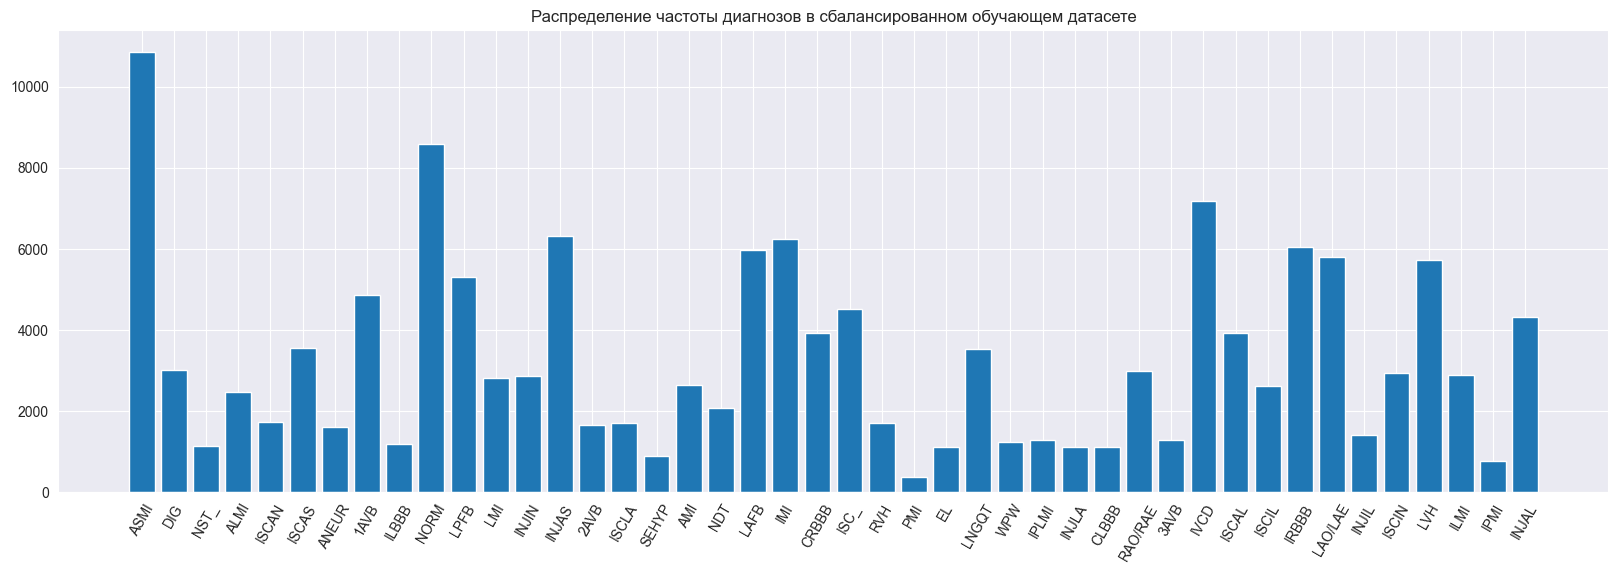

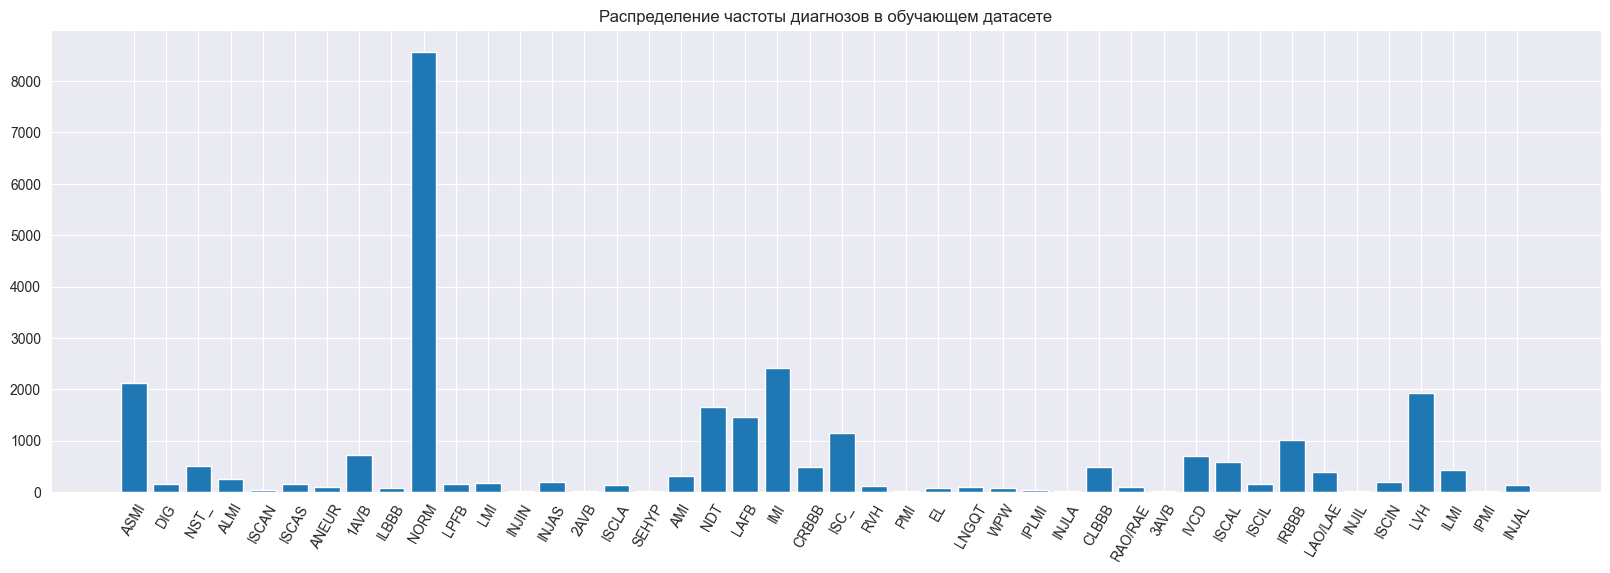

In [19]:
num_classes_dataset(Y_train_balanced, 'сбалансированном обучающем')
num_classes_dataset(Y_train, 'обучающем')

## Подготовка моделей классификатора

### Подготовка загрузчиков данных

In [ ]:
X_train = X_train.transpose(0,2,1)
X_train_balanced = X_train_balanced.transpose(0,2,1)
X_test = X_test.transpose(0,2,1)

In [268]:
X_train1 = torch.tensor(X_train, dtype=torch.float32)
Y_train1 = torch.tensor(Y_train, dtype=torch.float32)
X_train_balanced1 = torch.tensor(X_train_balanced, dtype=torch.float32)
Y_train_balanced1 = torch.tensor(Y_train_balanced, dtype=torch.float32)
X_test1 = torch.tensor(X_test, dtype=torch.float32)
Y_test1 = torch.tensor(Y_test, dtype=torch.float32)

Train_basic = torch.utils.data.DataLoader(tuple(zip(X_train1, Y_train1)), batch_size=256, shuffle=True)
Train_balanced = torch.utils.data.DataLoader(tuple(zip(X_train_balanced1, Y_train_balanced1)), batch_size=256, shuffle=True)
Test = torch.utils.data.DataLoader(tuple(zip(X_test1, Y_test1)), batch_size=256)



### Подготовка Рекурентной модели

In [269]:
class Network_gru(torch.nn.Module):
    def __init__(self, hidden1, hidden2):
        super().__init__()
        self.gru1 = torch.nn.GRU(input_size=12, hidden_size=hidden1, batch_first=True, bidirectional=True)
        self.gru2 = torch.nn.GRU(input_size=2*hidden1, hidden_size=hidden2, batch_first=True, bidirectional=True)
        self.flatten = torch.nn.Flatten()
        self.head = torch.nn.Linear(2*hidden2, len(diagnose_set))
        
    def forward(self, X):
        o1, s1 = self.gru1(X)
        o2, s2 = self.gru2(o1)
        flat = self.flatten(torch.transpose(s2, 0, 1))
        out = self.head(flat)
        return out

criterion = torch.nn.MultiLabelSoftMarginLoss()

In [276]:
model_gru = Network_gru(64, 128)

### Функция обучения

In [306]:
def train_model(model, train, test, epoch_num, metrics_threshold, label, Y_real_train, Y_real_test, verbose=False, plot=True):
    
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    
    num_train = 0
    for i, (_, Y) in enumerate(train):
        num_train += torch.numel(Y)
        if verbose:
            print(f'считаем количество примеров обучающей выборки {i} из {len(train)}', end='\r')
    print('\n')
    num_test = 0
    for i, (_, Y) in enumerate(test):
        num_test += torch.numel(Y)
        if verbose:
            print(f'считаем количество примеров тестовой выборки {i} из {len(test)}', end='\r')
    print('\n')

    
    
    hist_train = np.empty(epoch_num)
    hist_test = np.empty(epoch_num)
    acc_train = np.empty(epoch_num)
    acc_test = np.empty(epoch_num)
    f1_train = np.empty((epoch_num, len(diagnose_set)))
    f1_test = np.empty((epoch_num, len(diagnose_set)))
    
    
    for i in range(epoch_num):      
        
        hist_train_epoch = 0
        acc_train_epoch = 0
        f1_train_epoch = np.zeros(len(diagnose_set))
        Pred_train = np.empty((1, len(diagnose_set)))
        
        model.train()
        for j, (X, Y) in enumerate(train): 
            X = X.to(device)
            Y = Y.to(device)
            optimizer.zero_grad()
            
            Y_pred = model(X)
            loss = criterion(Y_pred, Y)
            loss.backward()
            optimizer.step()
            
            hist_train_epoch += loss.item()
            Y_threshold = torch.sigmoid(Y_pred) >= metrics_threshold
            acc_train_epoch += (Y_threshold == (Y > 0)).sum().item()
            Pred_train = np.concatenate((Pred_train, Y_pred.cpu().detach().numpy()))

            # for k, (pred_col, trg_col) in enumerate(zip(Y_pred.T, Y.T)):
            #     f1_train_epoch[k] += torcheval.metrics.functional.binary_f1_score(pred_col, trg_col, threshold=metrics_threshold)

            if verbose:
                print(f"Пройден обучающий батч {j} из {len(train)}", end='\r')
        print('\n')


        
        hist_test_epoch = 0
        acc_test_epoch = 0
        f1_test_epoch = np.zeros(len(diagnose_set))
        Pred_test = np.empty((1, len(diagnose_set)))
        
        model.eval()
        for j, (X, Y) in enumerate(test):
            X = X.to(device)
            Y = Y.to(device)            
            Y_pred = model(X)
            loss = criterion(Y_pred, Y)

            hist_test_epoch += loss.item()
            Y_threshold = torch.sigmoid(Y_pred) >= metrics_threshold
            acc_test_epoch += (Y_threshold == (Y > 0)).sum().item()
            Pred_test = np.concatenate((Pred_test, Y_pred.cpu().detach().numpy()))

            # for k, (pred_col, trg_col) in enumerate(zip(Y_pred.T, Y.T)):
            #     f1_train_epoch[k] += torcheval.metrics.functional.binary_f1_score(pred_col, trg_col, threshold=metrics_threshold)

            if verbose:
                print(f"Пройден тестовый батч {j} из {len(test)}", end='\r')
        print('\n')

        for k, (pred_col, trg_col) in enumerate(zip(Pred_train[1:].T, Y_real_train.T)):
            f1_train[i, k] += torcheval.metrics.functional.binary_f1_score(torch.tensor(pred_col), trg_col, threshold=metrics_threshold)

        for k, (pred_col, trg_col) in enumerate(zip(Pred_test[1:].T, Y_real_test.T)):
            f1_test[i, k] += torcheval.metrics.functional.binary_f1_score(torch.tensor(pred_col), trg_col, threshold=metrics_threshold)

        hist_train[i] = hist_train_epoch/len(train)
        hist_test[i] = hist_test_epoch/len(test)
        acc_train[i] = acc_train_epoch/num_train*100
        acc_test[i] = acc_test_epoch/num_test*100
        # f1_train[i] = f1_train_epoch
        # f1_test[i] = f1_test_epoch

        if verbose:
            if (i) % verbose == 0:
                print(f"Пройдена эпоха {i+1} из {epoch_num}, результаты:")
                print(f"Loss Train / Test: {hist_train[i]} / {hist_test[i]}")
                print(f"Accuracy Train / Test: {acc_train[i]}% / {acc_test[i]}%")
                print(f"F1 Train / Test: {f1_train[i]}%  \n {f1_test[i]}%")

    if plot:
        plt.figure(figsize=(16, 6))        
        plt.plot(hist_test, label=f"Loss test {label}")
        plt.plot(hist_train, label=f"Loss train {label}")
        plt.grid()
        plt.legend()
        
        plt.figure(figsize=(16, 6)) 
        plt.plot(acc_test, label=f"% Acc test {label}")
        plt.plot(acc_train, label=f"% Acc train {label}")
        plt.grid()
        plt.legend()

    return (hist_train, hist_test, acc_train, acc_test, f1_train, f1_test)

считаем количество примеров обучающей выборки 194 из 195

считаем количество примеров тестовой выборки 8 из 9

Пройден обучающий батч 194 из 195

Пройден тестовый батч 8 из 9

Пройдена эпоха 1 из 2, результаты:
Loss Train / Test: 0.1127867422806911 / 0.0887062441971567
Accuracy Train / Test: 96.31587539284014% / 97.03662433773442%
F1 Train / Test: [0.16801164 0.05318537 0.         0.03444656 0.03762012 0.06866793
 0.02422163 0.0460048  0.0215163  0.02018924 0.11012471 0.04176052
 0.05643667 0.1198715  0.02793696 0.01965602 0.01611958 0.03874373
 0.00266353 0.09158709 0.03751427 0.08195207 0.05512704 0.03686579
 0.00735767 0.01544913 0.06655458 0.02744913 0.02691428 0.02105078
 0.01090037 0.06216912 0.02382725 0.11891433 0.05383347 0.05281531
 0.09038088 0.08951783 0.02539145 0.0339974  0.07578431 0.05173573
 0.00602833 0.08212388]%  
 [3.77243698e-01 0.00000000e+00 0.00000000e+00            nan
 0.00000000e+00 0.00000000e+00 1.05448000e-01            inf
            inf 6.34391248e-01 

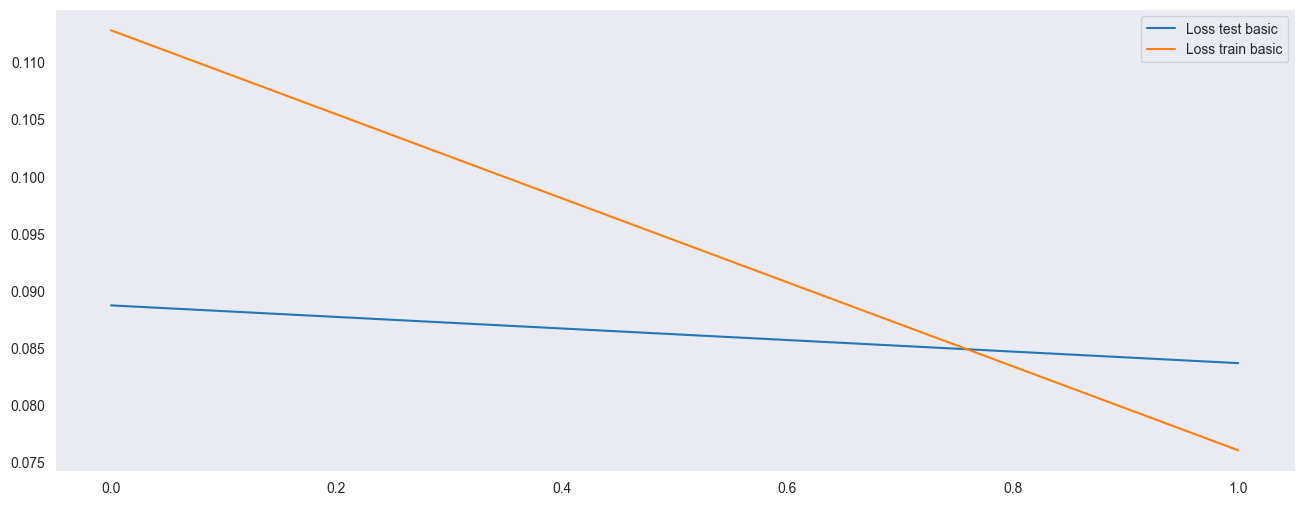

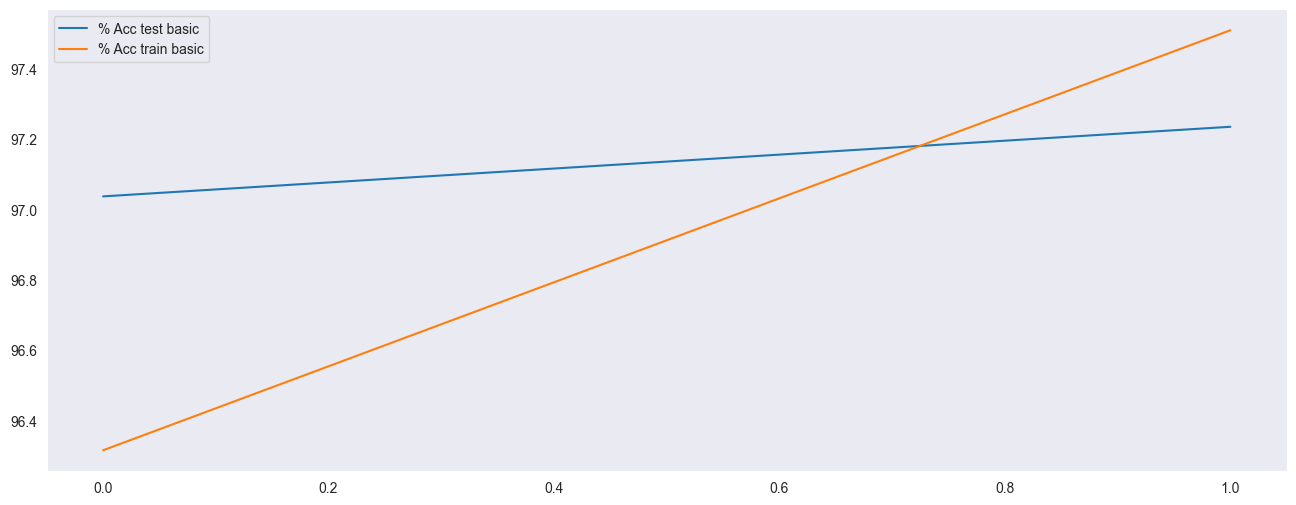

In [309]:
ttt = train_model(model_gru, Train_balanced, Test, 2, 0.5, 'basic', Y_train_balanced1, Y_test1, verbose=1)

In [108]:
a, b = next(iter(Train_basic))

In [99]:
a.shape

torch.Size([256, 1000, 12])

In [100]:
b.shape

torch.Size([256, 44])

In [144]:
tt = model_gru(a)

In [89]:
a.dtype

torch.int64

In [118]:
gru1 = torch.nn.GRU(input_size=12, hidden_size=64, batch_first=True, bidirectional=True)
gru2 = torch.nn.GRU(input_size=2*64, hidden_size=100, batch_first=True, bidirectional=True)

In [119]:
o1, s1 = gru1(a)

In [120]:
o2, s2 = gru2(o1)

In [121]:
s2.shape

torch.Size([2, 256, 100])

In [141]:
s22 = torch.transpose(s2, 0, 1)

torch.Tensor

In [123]:
s22.shape

torch.Size([256, 2, 100])

In [124]:
m = torch.nn.Flatten()
output = m(s22)

In [140]:
type(output)

torch.Tensor

In [146]:
tt.shape

torch.Size([256, 44])

In [164]:
criterion = torch.nn.MultiLabelSoftMarginLoss()

In [160]:
criterion(tt, b)

tensor(0.6933, grad_fn=<MeanBackward0>)

In [212]:
tt.shape

torch.Size([256, 44])

In [155]:
b

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.5000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.1500, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])

In [194]:
criterion(torch.tensor([-1, 0, 1], dtype=torch.float32), torch.tensor([0, 0.5, 1], dtype=torch.float32))

tensor(0.4399)

In [195]:
torch.sigmoid(tt)

tensor([[0.4805, 0.4985, 0.4953,  ..., 0.4941, 0.4797, 0.4789],
        [0.4802, 0.4961, 0.4979,  ..., 0.4948, 0.4777, 0.4783],
        [0.4813, 0.4991, 0.4926,  ..., 0.4934, 0.4790, 0.4749],
        ...,
        [0.4835, 0.4978, 0.4946,  ..., 0.4959, 0.4793, 0.4772],
        [0.4832, 0.4958, 0.4942,  ..., 0.4938, 0.4810, 0.4782],
        [0.4837, 0.4959, 0.4942,  ..., 0.4929, 0.4797, 0.4774]],
       grad_fn=<SigmoidBackward0>)

In [211]:
import torch
from torcheval.metrics.functional import multiclass_f1_score

input = torch.tensor([[0.9, 0, 0, 1], [0.1, 0.9, 0.4, 0.3]])
target = torch.tensor([1, 0])
multiclass_f1_score(input, target,  average="macro")


ValueError: num_classes should be a positive number when average=macro, got num_classes=None.

In [238]:
import torcheval
for aa, bb in zip(inp.T, trg.T):
    print(torcheval.metrics.functional.binary_f1_score(aa, bb))

tensor(0.6667)
tensor(0.6667)
tensor(1.)


In [237]:
inp = torch.tensor([[0, 0.5, 1], [0.2, 0.2, 0.8], [0.7, 0.3, 0.6], [0.1, 1, 0.2]])
trg = torch.tensor([[1, 1, 1], [0, 0, 1], [1, 0, 1], [0, 0, 0]])

In [300]:
av = np.zeros((1, 3))

In [302]:
av = np.concatenate((av, [[1, 2, 3], [4, 5, 6]]))

In [255]:
a = a.to(device)

In [256]:
asf(a)

tensor([[ 0.1291,  0.1330,  0.0399,  ..., -0.0125, -0.0152, -0.0381],
        [ 0.1302,  0.1425,  0.0306,  ..., -0.0200, -0.0187, -0.0689],
        [ 0.1143,  0.1340,  0.0475,  ..., -0.0282,  0.0011, -0.0429],
        ...,
        [ 0.1471,  0.1280,  0.0205,  ..., -0.0214, -0.0071, -0.0339],
        [ 0.1120,  0.1461,  0.0522,  ..., -0.0218, -0.0008, -0.0401],
        [ 0.1127,  0.1420,  0.0577,  ..., -0.0215,  0.0013, -0.0411]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

In [303]:
av

array([[0., 0., 0.],
       [1., 2., 3.],
       [4., 5., 6.],
       [1., 2., 3.],
       [4., 5., 6.]])